## OBA Algorithm Demo

The NeRF part is from "Tiny NeRF (A PyTorch implementation)"

So, this weekend, I was catching up on this _cool paper_ titled [*NeRF: Representing scenes as neural radiance fields for view synthesis*](https://arxiv.org/abs/2003.08934)!

The authors released a TensorFlow implementation [here](https://github.com/bmild/nerf). Deciding to delve deeper, I ported their code to PyTorch, cause why not!

> *DISCLAIMER*: This notebook (and repository) is work-in-progress. Although I have rigorously tested most modules in here (to faithfully replicate the original implementation), my implementation at places deviates from the authors'. Comments/criticism welcome!

> All functions that have a `#TESTED` under the docstring imply that they have been tested against their corresponding tensorflow impls.

In [81]:
# Import all the good stuff
from typing import Optional

import numpy as np
import torch
import matplotlib.pyplot as plt
import math
import cv2

## A few utility functions

#### Bridging PyTorch and TensorFlow functionality

There's plenty of differences in function signatures (and in functionality) b/w PyTorch and TensorFlow. Here's a few modules that help bridge the gap (for this particular impl).

In [82]:
def meshgrid_xy(tensor1: torch.Tensor, tensor2: torch.Tensor) -> (torch.Tensor, torch.Tensor):
    """Mimick np.meshgrid(..., indexing="xy") in pytorch. torch.meshgrid only allows "ij" indexing.
    (If you're unsure what this means, safely skip trying to understand this, and run a tiny example!)

    Args:
      tensor1 (torch.Tensor): Tensor whose elements define the first dimension of the returned meshgrid.
      tensor2 (torch.Tensor): Tensor whose elements define the second dimension of the returned meshgrid.
    """
    # TESTED
    ii, jj = torch.meshgrid(tensor1, tensor2)
    return ii.transpose(-1, -2), jj.transpose(-1, -2)


def cumprod_exclusive(tensor: torch.Tensor) -> torch.Tensor:
  r"""Mimick functionality of tf.math.cumprod(..., exclusive=True), as it isn't available in PyTorch.

  Args:
    tensor (torch.Tensor): Tensor whose cumprod (cumulative product, see `torch.cumprod`) along dim=-1
      is to be computed.

  Returns:
    cumprod (torch.Tensor): cumprod of Tensor along dim=-1, mimiciking the functionality of
      tf.math.cumprod(..., exclusive=True) (see `tf.math.cumprod` for details).
  """
  # TESTED
  # Only works for the last dimension (dim=-1)
  dim = -1
  # Compute regular cumprod first (this is equivalent to `tf.math.cumprod(..., exclusive=False)`).
  cumprod = torch.cumprod(tensor, dim)
  # "Roll" the elements along dimension 'dim' by 1 element.
  cumprod = torch.roll(cumprod, 1, dim)
  # Replace the first element by "1" as this is what tf.cumprod(..., exclusive=True) does.
  cumprod[..., 0] = 1.

  return cumprod

#### Compute the "bundle" of rays through all pixels of an image.

In [83]:
def get_ray_bundle(height: int, width: int, focal_length: float, tform_cam2world: torch.Tensor):
  r"""Compute the bundle of rays passing through all pixels of an image (one ray per pixel).

  Args:
    height (int): Height of an image (number of pixels).
    width (int): Width of an image (number of pixels).
    focal_length (float or torch.Tensor): Focal length (number of pixels, i.e., calibrated intrinsics).
    tform_cam2world (torch.Tensor): A 6-DoF rigid-body transform (shape: :math:`(4, 4)`) that
      transforms a 3D point from the camera frame to the "world" frame for the current example.

  Returns:
    ray_origins (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the centers of
      each ray. `ray_origins[i][j]` denotes the origin of the ray passing through pixel at
      row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
    ray_directions (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the
      direction of each ray (a unit vector). `ray_directions[i][j]` denotes the direction of the ray
      passing through the pixel at row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
  """
  # TESTED
  ii, jj = meshgrid_xy(
      torch.arange(width).to(tform_cam2world),
      torch.arange(height).to(tform_cam2world)
  )
  directions = torch.stack([(ii - width * .5) / focal_length,
                            -(jj - height * .5) / focal_length,
                            -torch.ones_like(ii)
                           ], dim=-1)
  ray_directions = torch.sum(directions[..., None, :] * tform_cam2world[:3, :3], dim=-1)
  ray_origins = tform_cam2world[:3, -1].expand(ray_directions.shape)
  # print(ray_origins)
  return ray_origins, ray_directions

#### Compute "query" 3D points given the "bundle" of rays.

We assume that a _near_ and a _far_ clipping distance are provided that delineate the volume of interest. Each ray is evaluated only within these bounds. We randomly sample points along each ray, while trying to ensure most parts of the ray's trajectory are spanned.

In [84]:
def compute_query_points_from_rays(
    ray_origins: torch.Tensor,
    ray_directions: torch.Tensor,
    near_thresh: float,
    far_thresh: float,
    num_samples: int,
    randomize: Optional[bool] = True
) -> (torch.Tensor, torch.Tensor):
  r"""Compute query 3D points given the "bundle" of rays. The near_thresh and far_thresh
  variables indicate the bounds within which 3D points are to be sampled.

  Args:
    ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    ray_directions (torch.Tensor): Direction of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    near_thresh (float): The 'near' extent of the bounding volume (i.e., the nearest depth
      coordinate that is of interest/relevance).
    far_thresh (float): The 'far' extent of the bounding volume (i.e., the farthest depth
      coordinate that is of interest/relevance).
    num_samples (int): Number of samples to be drawn along each ray. Samples are drawn
      randomly, whilst trying to ensure "some form of" uniform spacing among them.
    randomize (optional, bool): Whether or not to randomize the sampling of query points.
      By default, this is set to `True`. If disabled (by setting to `False`), we sample
      uniformly spaced points along each ray in the "bundle".

  Returns:
    query_points (torch.Tensor): Query points along each ray
      (shape: :math:`(width, height, num_samples, 3)`).
    depth_values (torch.Tensor): Sampled depth values along each ray
      (shape: :math:`(num_samples)`).
  """
  # TESTED
  # shape: (num_samples)
  depth_values = torch.linspace(near_thresh, far_thresh, num_samples).to(ray_origins)
  if randomize is True:
    # ray_origins: (width, height, 3)
    # noise_shape = (width, height, num_samples)
    noise_shape = list(ray_origins.shape[:-1]) + [num_samples]
    # depth_values: (num_samples)
    depth_values = depth_values \
        + torch.rand(noise_shape).to(ray_origins) * (far_thresh
            - near_thresh) / num_samples
  # (width, height, num_samples, 3) = (width, height, 1, 3) + (width, height, 1, 3) * (num_samples, 1)
  # query_points:  (width, height, num_samples, 3)
  query_points = ray_origins[..., None, :] + ray_directions[..., None, :] * depth_values[..., :, None]
  # TODO: Double-check that `depth_values` returned is of shape `(num_samples)`.
  return query_points, depth_values

In [85]:
def query_points_for_one_ray(
    x: int,
    y: int,
    ray_origins: torch.Tensor,
    ray_directions: torch.Tensor,
    near_thresh: float,
    far_thresh: float,
    num_samples: int,
    randomize: Optional[bool] = True
) -> (torch.Tensor, torch.Tensor):
  r"""Compute query 3D points given the "bundle" of rays. The near_thresh and far_thresh
  variables indicate the bounds within which 3D points are to be sampled.

  Args:
    x: x coordinate of the pixel on the image
    y: y coordinate of the pixel on the image
    ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    ray_directions (torch.Tensor): Direction of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    near_thresh (float): The 'near' extent of the bounding volume (i.e., the nearest depth
      coordinate that is of interest/relevance).
    far_thresh (float): The 'far' extent of the bounding volume (i.e., the farthest depth
      coordinate that is of interest/relevance).
    num_samples (int): Number of samples to be drawn along each ray. Samples are drawn
      randomly, whilst trying to ensure "some form of" uniform spacing among them.
    randomize (optional, bool): Whether or not to randomize the sampling of query points.
      By default, this is set to `True`. If disabled (by setting to `False`), we sample
      uniformly spaced points along each ray in the "bundle".

  Returns:
    query_points (torch.Tensor): Query points along each ray
      (shape: :math:`(width, height, num_samples, 3)`).
    depth_values (torch.Tensor): Sampled depth values along each ray
      (shape: :math:`(num_samples)`).
  """
  # TESTED
  # shape: (num_samples)
  depth_values = torch.linspace(near_thresh, far_thresh, num_samples).to(ray_origins)
  if randomize is True:
    # ray_origins: (width, height, 3)
    # noise_shape = (width, height, num_samples)
    noise_shape = list(ray_origins.shape[:-1]) + [num_samples]
    # depth_values: (num_samples)
    depth_values = depth_values \
        + torch.rand(noise_shape).to(ray_origins) * (far_thresh
            - near_thresh) / num_samples
  # (width, height, num_samples, 3) = (width, height, 1, 3) + (width, height, 1, 3) * (num_samples, 1)
  # query_points:  (width, height, num_samples, 3)
  # TODO: Double-check that `depth_values` returned is of shape `(num_samples)`.
  return query_points, depth_values

#### Volumetric rendering

> **NOTE**: This volumetric rendering module (like the authors' tiny_nerf [Colab notebook](https://colab.research.google.com/github/bmild/nerf/blob/master/tiny_nerf.ipynb) does not implement 5D input (which includes view directions, in addition to X, Y, Z coordinates). It also does not implement the hierarchical sampling procedure. For those implementations, refer to the other complete examples in the repo.

In [86]:
def render_volume_density(
    radiance_field: torch.Tensor,
    ray_origins: torch.Tensor,
    depth_values: torch.Tensor
) -> (torch.Tensor, torch.Tensor, torch.Tensor):
  r"""Differentiably renders a radiance field, given the origin of each ray in the
  "bundle", and the sampled depth values along them.

  Args:
    radiance_field (torch.Tensor): A "field" where, at each query location (X, Y, Z),
      we have an emitted (RGB) color and a volume density (denoted :math:`\sigma` in
      the paper) (shape: :math:`(width, height, num_samples, 4)`).
    ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    depth_values (torch.Tensor): Sampled depth values along each ray
      (shape: :math:`(num_samples)`).

  Returns:
    rgb_map (torch.Tensor): Rendered RGB image (shape: :math:`(width, height, 3)`).
    depth_map (torch.Tensor): Rendered depth image (shape: :math:`(width, height)`).
    acc_map (torch.Tensor): # TODO: Double-check (I think this is the accumulated
      transmittance map).
  """
  # print(radiance_field)
  # TESTED
  sigma_a = torch.nn.functional.relu(radiance_field[..., 3])
  rgb = torch.sigmoid(radiance_field[..., :3])
  one_e_10 = torch.tensor([1e10], dtype=ray_origins.dtype, device=ray_origins.device)
  dists = torch.cat((depth_values[..., 1:] - depth_values[..., :-1],
                  one_e_10.expand(depth_values[..., :1].shape)), dim=-1)
  alpha = 1. - torch.exp(-sigma_a * dists)
  weights = alpha * cumprod_exclusive(1. - alpha + 1e-10)

  rgb_map = (weights[..., None] * rgb).sum(dim=-2)
  depth_map = (weights * depth_values).sum(dim=-1)
  acc_map = weights.sum(-1)

  return rgb_map, depth_map, acc_map

#### Positional encoding

Another interesting tweak used in NeRF is "positional encoding", which postulates the use of a mapping to higher dimensional space (using a basis set of high-frequency functions). This greatly enhances the model's capability to capture high-frequency variations.

In [87]:
def positional_encoding(
    tensor, num_encoding_functions=6, include_input=True, log_sampling=True
) -> torch.Tensor:
  r"""Apply positional encoding to the input.

  Args:
    tensor (torch.Tensor): Input tensor to be positionally encoded.
    num_encoding_functions (optional, int): Number of encoding functions used to
        compute a positional encoding (default: 6).
    include_input (optional, bool): Whether or not to include the input in the
        computed positional encoding (default: True).
    log_sampling (optional, bool): Sample logarithmically in frequency space, as
        opposed to linearly (default: True).

  Returns:
    (torch.Tensor): Positional encoding of the input tensor.
  """
  # TESTED
  # Trivially, the input tensor is added to the positional encoding.
  encoding = [tensor] if include_input else []
  # Now, encode the input using a set of high-frequency functions and append the
  # resulting values to the encoding.
  frequency_bands = None
  if log_sampling:
      frequency_bands = 2.0 ** torch.linspace(
            0.0,
            num_encoding_functions - 1,
            num_encoding_functions,
            dtype=tensor.dtype,
            device=tensor.device,
        )
  else:
      frequency_bands = torch.linspace(
          2.0 ** 0.0,
          2.0 ** (num_encoding_functions - 1),
          num_encoding_functions,
          dtype=tensor.dtype,
          device=tensor.device,
      )

  for freq in frequency_bands:
      for func in [torch.sin, torch.cos]:
          encoding.append(func(tensor * freq))

  # Special case, for no positional encoding
  if len(encoding) == 1:
      return encoding[0]
  else:
      return torch.cat(encoding, dim=-1)

## NeRF: Network architecture

In [88]:
class VeryTinyNerfModel(torch.nn.Module):
  r"""Define a "very tiny" NeRF model comprising three fully connected layers.
  """
  def __init__(self, filter_size=128, num_encoding_functions=6):
    super(VeryTinyNerfModel, self).__init__()
    # Input layer (default: 39 -> 128)
    self.layer1 = torch.nn.Linear(3 + 3 * 2 * num_encoding_functions, filter_size)
    # Layer 2 (default: 128 -> 128)
    self.layer2 = torch.nn.Linear(filter_size, filter_size)
    # Layer 3 (default: 128 -> 4)
    self.layer3 = torch.nn.Linear(filter_size, 4)
    # Short hand for torch.nn.functional.relu
    self.relu = torch.nn.functional.relu

  def forward(self, x):
    x = self.relu(self.layer1(x))
    x = self.relu(self.layer2(x))
    x = self.layer3(x)
    return x

## Dataloading utils

In [89]:
def get_minibatches(inputs: torch.Tensor, chunksize: Optional[int] = 1024 * 8):
  r"""Takes a huge tensor (ray "bundle") and splits it into a list of minibatches.
  Each element of the list (except possibly the last) has dimension `0` of length
  `chunksize`.
  """
  return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]

## Get data

In [90]:
# Download sample data used in the official tiny_nerf example
import os
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

## Determine device to run on (GPU vs CPU)

In [91]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


## Load up input images, poses, intrinsics, etc.

In [92]:
# Load input images, poses, and intrinsics
data = np.load("tiny_nerf_data.npz")

print(data)

# Images
images = data["images"]
# Camera extrinsics (poses)
tform_cam2world = data["poses"]

print(tform_cam2world[0])
testpose_groundtruth = tform_cam2world[50].copy()

# for transform_for_one_frame in tform_cam2world:
    # for rotation, add a smaller noise
    # transform_for_one_frame[0, 0] += np.random.normal(0, 0.01)
    # transform_for_one_frame[0, 1] += np.random.normal(0, 0.01)
    # transform_for_one_frame[0, 2] += np.random.normal(0, 0.01)
    # transform_for_one_frame[1, 0] += np.random.normal(0, 0.01)
    # transform_for_one_frame[1, 1] += np.random.normal(0, 0.01)
    # transform_for_one_frame[1, 2] += np.random.normal(0, 0.01)
    # transform_for_one_frame[2, 0] += np.random.normal(0, 0.01)
    # transform_for_one_frame[2, 1] += np.random.normal(0, 0.01)
    # transform_for_one_frame[2, 2] += np.random.normal(0, 0.01)

    # for translation, add a bigger noise
    # transform_for_one_frame[0, 3] += np.random.normal(0, 0.01)
    # transform_for_one_frame[1, 3] += np.random.normal(0, 0.01)
    # transform_for_one_frame[2, 3] += np.random.normal(0, 0.01)

print("####################")
print(tform_cam2world[0])

tform_cam2world = torch.from_numpy(tform_cam2world).to(device)
# Focal length (intrinsics)
focal_length = data["focal"]
print(type(focal_length))
focal_length = torch.from_numpy(focal_length).to(device)

# Height and width of each image
height, width = images.shape[1:3]

# Near and far clipping thresholds for depth values.
near_thresh = 2.
far_thresh = 6.

# Hold one image out (for test).
testimg, testpose = images[50], tform_cam2world[50]
testimg = torch.from_numpy(testimg).to(device)

# Map images to device
images = torch.from_numpy(images[:100, ..., :3]).to(device)

[[-9.9990219e-01  4.1922452e-03 -1.3345719e-02 -5.3798322e-02]
 [-1.3988681e-02 -2.9965907e-01  9.5394367e-01  3.8454704e+00]
 [-4.6566129e-10  9.5403719e-01  2.9968831e-01  1.2080823e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
####################
[[-9.9990219e-01  4.1922452e-03 -1.3345719e-02 -5.3798322e-02]
 [-1.3988681e-02 -2.9965907e-01  9.5394367e-01  3.8454704e+00]
 [-4.6566129e-10  9.5403719e-01  2.9968831e-01  1.2080823e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
<class 'numpy.ndarray'>


#### Display the image used for testing

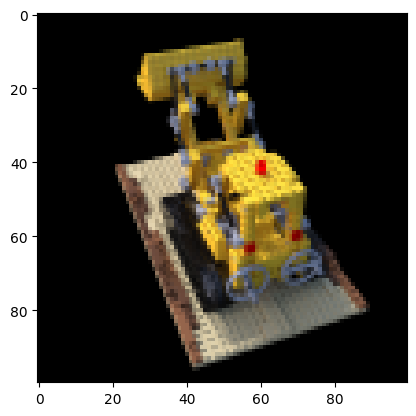

In [93]:
plt.imshow(testimg.detach().cpu().numpy())
plt.show()

## Train TinyNeRF!

(The cool part!)

In [94]:
# One iteration of TinyNeRF (forward pass).
def run_one_iter_of_tinynerf(height, width, focal_length, tform_cam2world,
                             near_thresh, far_thresh, depth_samples_per_ray,
                             encoding_function, get_minibatches_function):

  # Get the "bundle" of rays through all image pixels.
  ray_origins, ray_directions = get_ray_bundle(height, width, focal_length,
                                               tform_cam2world)

  # Sample query points along each ray
  query_points, depth_values = compute_query_points_from_rays(
      ray_origins, ray_directions, near_thresh, far_thresh, depth_samples_per_ray
  )

  # "Flatten" the query points.
  flattened_query_points = query_points.reshape((-1, 3))

  # Encode the query points (default: positional encoding).
  encoded_points = encoding_function(flattened_query_points)

  # Split the encoded points into "chunks", run the model on all chunks, and
  # concatenate the results (to avoid out-of-memory issues).
  batches = get_minibatches_function(encoded_points, chunksize=chunksize)
  predictions = []
  for batch in batches:
    predictions.append(model(batch))
  radiance_field_flattened = torch.cat(predictions, dim=0)

  # "Unflatten" to obtain the radiance field.
  unflattened_shape = list(query_points.shape[:-1]) + [4]
  radiance_field = torch.reshape(radiance_field_flattened, unflattened_shape)

  # Perform differentiable volume rendering to re-synthesize the RGB image.
  rgb_predicted, depth_predicted, _ = render_volume_density(radiance_field, ray_origins, depth_values)

  return rgb_predicted, depth_predicted

Loss: 0.1517079770565033


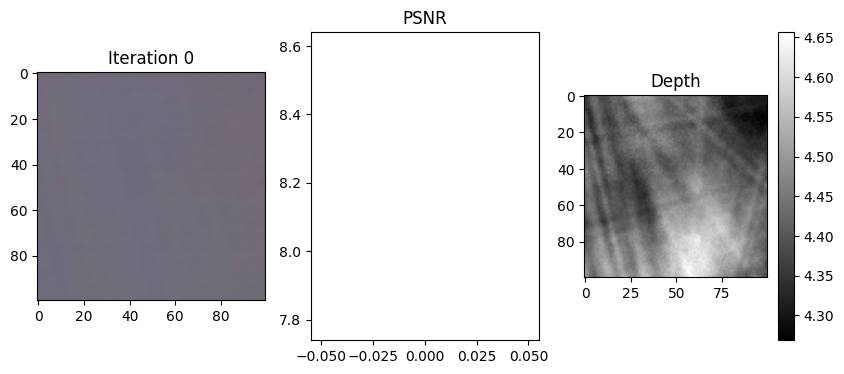

Loss: 0.08906897157430649


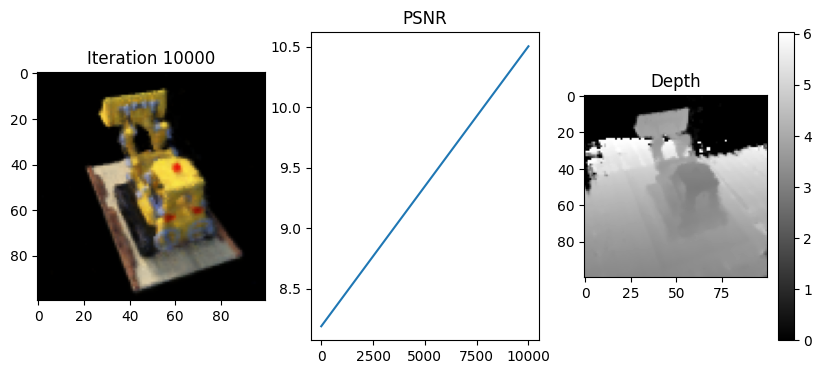

Loss: 0.040137361735105515


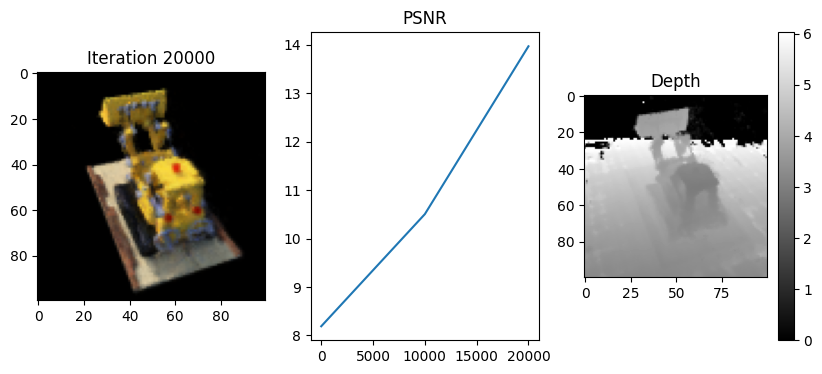

Loss: 0.08688522130250931


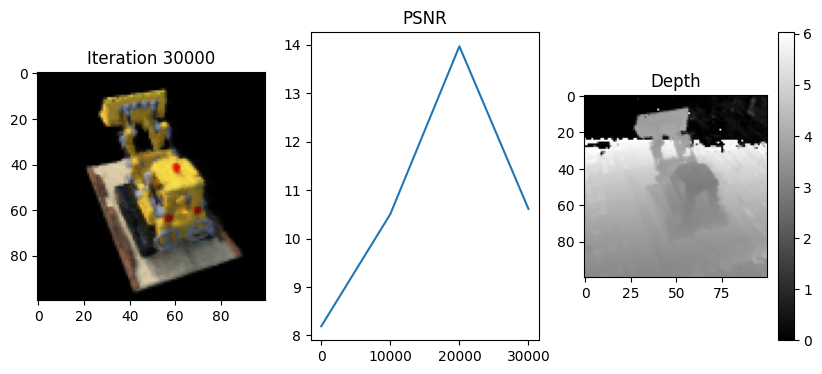

Loss: 0.05439751222729683


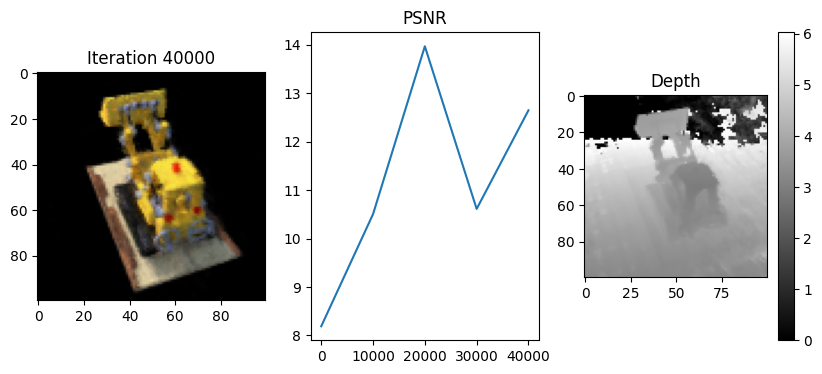

Loss: 0.07225527614355087


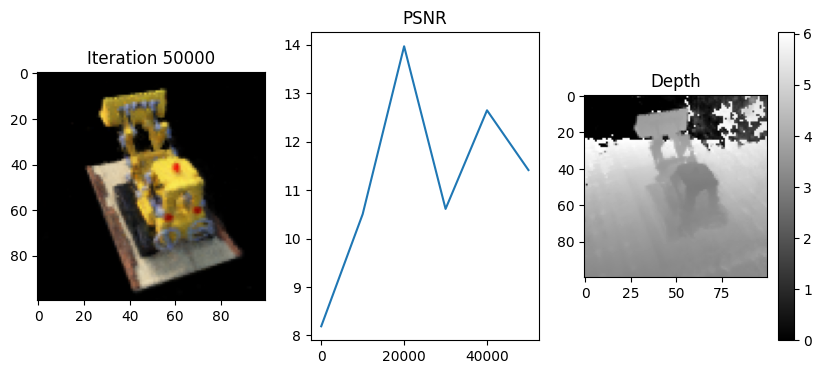

Loss: 0.08719716221094131


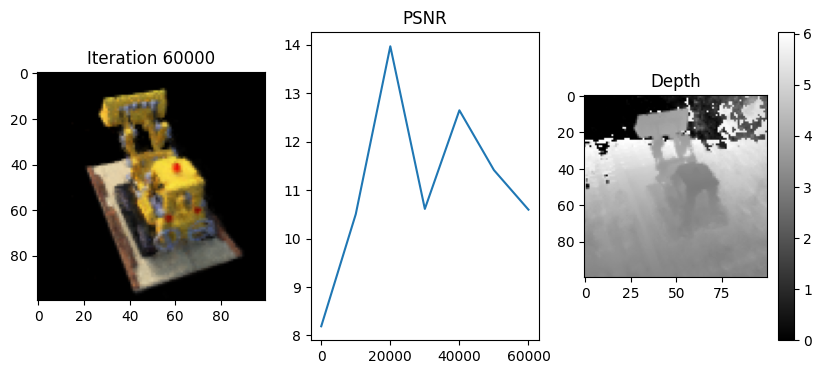

Loss: 0.08358986675739288


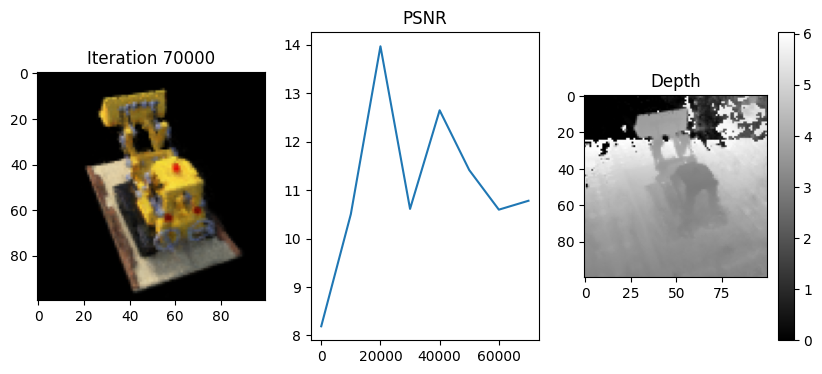

Loss: 0.0575556606054306


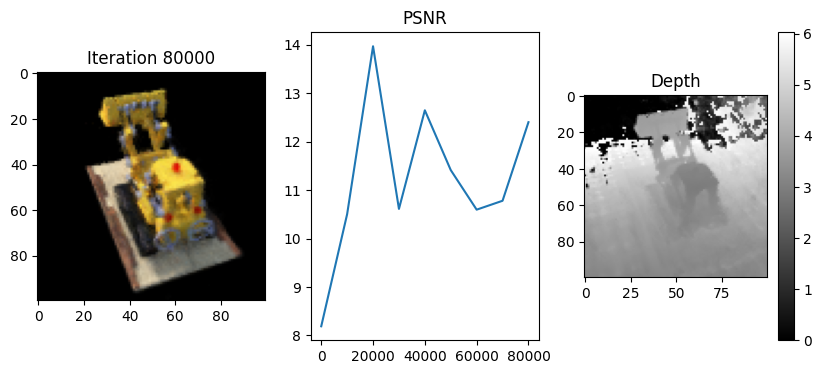

Loss: 0.04548998922109604


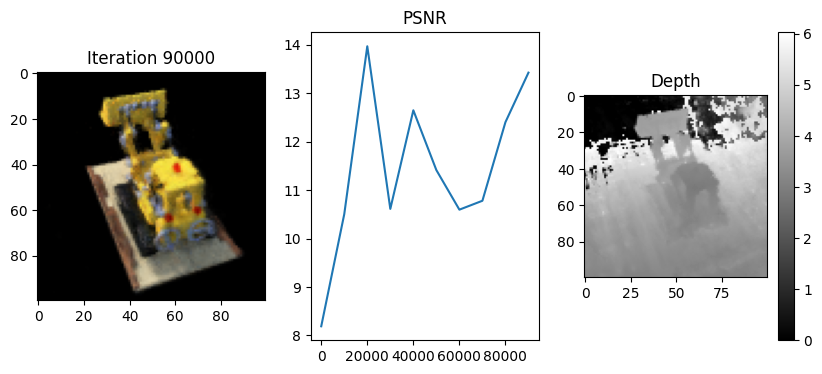

Done!


In [95]:
"""
Parameters for TinyNeRF training
"""

# Number of functions used in the positional encoding (Be sure to update the
# model if this number changes).
num_encoding_functions = 6
# Specify encoding function.
encode = lambda x: positional_encoding(x, num_encoding_functions=num_encoding_functions)
# Number of depth samples along each ray.
depth_samples_per_ray = 128

# Chunksize (Note: this isn't batchsize in the conventional sense. This only
# specifies the number of rays to be queried in one go. Backprop still happens
# only after all rays from the current "bundle" are queried and rendered).
chunksize = 16384  # Use chunksize of about 4096 to fit in ~1.4 GB of GPU memory.

# Optimizer parameters
lr = 5e-3
num_iters = 100000

# Misc parameters
display_every = 10000  # Number of iters after which stats are displayed

"""
Model
"""
model = VeryTinyNerfModel(num_encoding_functions=num_encoding_functions)
model.to(device)

"""
Optimizer
"""
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

"""
Train-Eval-Repeat!
"""

# Seed RNG, for repeatability
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

# Lists to log metrics etc.
psnrs = []
iternums = []

minimum_loss = math.inf
min_loss_image = None
min_loss_depth_field = None

for i in range(num_iters):

  # Randomly pick an image as the target.
  target_img_idx = np.random.randint(images.shape[0])
  target_img = images[target_img_idx].to(device)
  target_tform_cam2world = tform_cam2world[target_img_idx].to(device)

  # Run one iteration of TinyNeRF and get the rendered RGB image.
  rgb_predicted, depth_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                           target_tform_cam2world, near_thresh,
                                           far_thresh, depth_samples_per_ray,
                                           encode, get_minibatches)

  # Compute mean-squared error between the predicted and target images. Backprop!
  loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  # Display images/plots/stats
  if i % display_every == 0:
    # Render the held-out view
    rgb_predicted, depth_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                             testpose, near_thresh,
                                             far_thresh, depth_samples_per_ray,
                                             encode, get_minibatches)
    loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
    if loss < minimum_loss:
      minimum_loss = loss
      min_loss_image = rgb_predicted.detach().cpu().numpy()
      min_loss_depth_field = depth_predicted.detach().cpu().numpy()
      
    print("Loss:", loss.item())
    psnr = -10. * torch.log10(loss)

    psnrs.append(psnr.item())
    iternums.append(i)

    plt.figure(figsize=(10, 4))
    plt.subplot(131)
    plt.imshow(rgb_predicted.detach().cpu().numpy())
    plt.title(f"Iteration {i}")
    plt.subplot(132)
    plt.plot(iternums, psnrs)
    plt.title("PSNR")

    depth_field = depth_predicted.detach().cpu().numpy()
    plt.subplot(133)
    plt.imshow(depth_field, cmap='gray')
    plt.colorbar()  # Add a colorbar for reference
    plt.title("Depth")

    plt.show()

# Convert the image from RGB to BGR
bgr_predicted_np = cv2.cvtColor(min_loss_image, cv2.COLOR_RGB2BGR)
# Rescale the image from [0,1] to [0,255] and convert to uint8
bgr_predicted_np = (bgr_predicted_np * 255).astype(np.uint8)
# Save the image
cv2.imwrite('min_loss_image.jpg', bgr_predicted_np)

print('Done!')

## After we got NeRF model, we extract ORB feature points

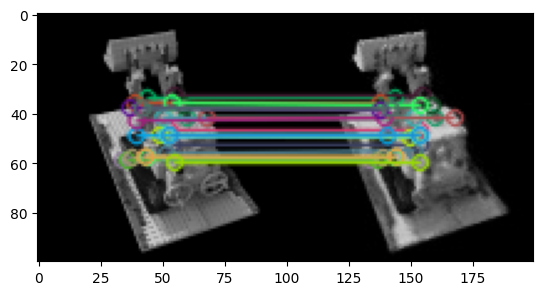

True

In [96]:
import cv2
from matplotlib import pyplot as plt

number_of_match = 25

# Load images
img1 = data["images"][50]  # ground truth of test image
synthesized_image_path = "min_loss_image.jpg"  
img2 = cv2.imread(synthesized_image_path, 0)  # synthesized image by NeRF

img1 = cv2.convertScaleAbs(img1, alpha=(255.0))
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
# img2 = cv2.convertScaleAbs(img2, alpha=(255.0))

# Initialize ORB detector
orb = cv2.ORB_create()

# Find keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# Create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(des1, des2)

# Sort them in ascending order of distance
matches = sorted(matches, key=lambda x: x.distance)

# Draw first 10 matches
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:number_of_match], None, flags=2)

# Display the image
plt.imshow(img3), plt.show()

# Save the image
cv2.imwrite('matched_features_bulldozer.jpg', img3)

## Get the distance for each match point on synthesized image

In [97]:

matched_points_img2 = [kp2[match.trainIdx].pt for match in matches[:number_of_match]]

print(len(matched_points_img2))
distance_for_each_point = []

for point in matched_points_img2:
    x_coord = int(round(point[0]))
    y_coord = int(round(point[1]))
    distance = min_loss_depth_field[x_coord, y_coord]
    distance_for_each_point.append(distance)

25


## Convert each match point to world frame 3d point

In [98]:
def get_3d_coordinates(x, y, d, intrinsics, tform_cam2world):
    # Create a vector for the image point with the depth
    # Note: the pixel coordinates must be normalized by subtracting the principal point and dividing by the focal length
    img_point = np.array([(x - intrinsics[0, 2]) / intrinsics[0, 0], 
                          (y - intrinsics[1, 2]) / intrinsics[1, 1], 
                          1.0]) * d

    # Convert the image point to homogeneous coordinates
    img_point_homogeneous = np.append(img_point, 1)

    # Multiply the transformation matrix by the image point to get the 3D point
    point_3d = np.dot(tform_cam2world, img_point_homogeneous)

    # Convert the 3D point back to non-homogeneous coordinates
    point_3d = point_3d / point_3d[3]

    return point_3d

In [99]:
focal_length = float(data["focal"])
intrinsics = np.array([[focal_length, 0, width * .5], [0, focal_length, width * .5], [0, 0, 1]])
tform_cam2world = testpose.detach().cpu().numpy()
point_3d_list = []

for i in range(number_of_match):
    point = matched_points_img2[i]
    x_coord = int(round(point[0]))
    y_coord = int(round(point[1]))
    distance = distance_for_each_point[i]
    point_3d = get_3d_coordinates(x_coord, y_coord, distance, intrinsics, tform_cam2world)
    point_3d_list.append(point_3d[0:3])

## Batch Adjustment

In [100]:
from scipy.optimize import least_squares

points_2d = np.array(matched_points_img2)
points_3d = np.array(point_3d_list)

In [101]:
import cv2
import numpy as np

# convert tform_cam2world to a 9d vector representing pose
def convert_to_true_params(tform_cam2world, x0, y0, f):
    # Extract the rotation and translation from the transformation matrix
    R_world2cam = tform_cam2world[:3, :3]
    T_world2cam = tform_cam2world[:3, 3]

    # Convert the rotation matrix to a rotation vector
    rotation_vector, _ = cv2.Rodrigues(R_world2cam)

    # Construct the true_params vector
    true_params = np.concatenate(([x0, y0, f], rotation_vector.flatten(), T_world2cam.flatten()), dtype=np.float64)

    return true_params

In [102]:
# Convert to true_params format
initial_estimation = convert_to_true_params(tform_cam2world, width * .5, width * .5, focal_length)
print(initial_estimation)

# Define function to transform 3D points to 2D
def project(points, params):
    x0, y0, f = params[:3]
    rotation_vector = params[3:6].astype(np.float64)  # Ensure rotation vector is float64
    translation_vector = params[6:]

    R, _ = cv2.Rodrigues(rotation_vector)
    projected_points = np.dot(points, R.T) + translation_vector
    projected_points = projected_points[:, :2] / projected_points[:, 2, np.newaxis]
    projected_points *= f
    projected_points[:, 0] += x0
    projected_points[:, 1] += y0
    return projected_points

# Define reprojection error
def fun(params, n, m, points_2d, points_3d):
    projected_points = project(points_3d, params)
    return (projected_points - points_2d).ravel()

# Use the least_squares function to solve the bundle adjustment problem
res = least_squares(fun, initial_estimation, args=(2, 3, points_2d, points_3d))

# Print the true parameters and the ones estimated by bundle adjustment
# print('True pose: ', true_params)
print('#######################################')
print('initial pose: ', initial_estimation)
print('#######################################')
print('Estimated pose: ', res.x)

[ 50.          50.         138.8888789    0.22674397   1.21468854
   2.52305841   1.13680696   2.93888736   2.51408243]
#######################################
initial pose:  [ 50.          50.         138.8888789    0.22674397   1.21468854
   2.52305841   1.13680696   2.93888736   2.51408243]
#######################################
Estimated pose:  [ 5.30449070e+01  6.34031457e+01  1.33590411e+02  2.14087412e-01
  1.35904142e+00  3.18686448e+00  1.04286597e-01  3.71172873e-01
 -4.12517353e+00]


## Another method

In [103]:
import numpy as np
from scipy.optimize import least_squares
from scipy.spatial.transform import Rotation as R

def project(point_3d, pose):
    # pose is a 4x4 transformation matrix
    # Convert the 3D point to homogeneous coordinates
    point_3d_homogeneous = np.append(point_3d, 1)
    
    # Multiply the transformation matrix by the 3D point to get the projected point
    projected_point = np.dot(pose, point_3d_homogeneous)
    
    # Convert the projected point back to non-homogeneous coordinates
    projected_point = projected_point / projected_point[3]
    
    return projected_point[:2]

def fun(pose_params, points_2d, points_3d):
    # pose_params is a 1D array that contains the rotation as a quaternion and the translation
    rotation_quaternion = pose_params[:4]
    translation = pose_params[4:]
    
    # Convert the rotation from a quaternion to a matrix
    rotation_matrix = R.from_quat(rotation_quaternion).as_matrix()
    
    # Construct the pose matrix
    pose = np.eye(4)
    pose[:3, :3] = rotation_matrix
    pose[:3, 3] = translation
    
    # Project the 3D points using the pose matrix
    projected_points = np.array([project(p, pose) for p in points_3d])
    
    # Return the difference between the projected and observed 2D points
    return (projected_points - points_2d).ravel()

# Assume you have some 3D points and their corresponding 2D points
points_3d = np.random.rand(25, 3)
points_2d = np.random.rand(25, 2)

# You know the initial pose of the camera (identity transformation)
initial_pose = tform_cam2world

# Convert the rotation part of the pose to a quaternion
initial_rotation_quaternion = R.from_matrix(initial_pose[:3, :3]).as_quat()

# Get the translation part of the pose
initial_translation = initial_pose[:3, 3]

# Concatenate the rotation and translation into a 1D array
initial_pose_params = np.concatenate([initial_rotation_quaternion, initial_translation])

# Use the least_squares function to solve the optimization problem
res = least_squares(fun, initial_pose_params, args=(points_2d, points_3d))

# Print the initial and estimated poses
print('Initial pose:')
print(initial_pose)

estimated_rotation = R.from_quat(res.x[:4]).as_matrix()
estimated_translation = res.x[4:]
estimated_pose = np.eye(4)
estimated_pose[:3, :3] = estimated_rotation
estimated_pose[:3, 3] = estimated_translation

print('Estimated pose:')
print(estimated_pose)


Initial pose:
[[-0.93265635 -0.22499779  0.2820071   1.136807  ]
 [ 0.36076587 -0.581667    0.7290482   2.9388874 ]
 [ 0.          0.78169     0.62366706  2.5140824 ]
 [ 0.          0.          0.          1.        ]]
Estimated pose:
[[-0.50633098  0.7701018   0.38803628  0.09887322]
 [-0.76311447 -0.60970616  0.21427717  1.05652361]
 [ 0.40160334 -0.18762093  0.89638895  2.51408243]
 [ 0.          0.          0.          1.        ]]
